<a href="https://colab.research.google.com/github/robertviramontes/4840-automata/blob/master/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constants

In [61]:
# set up environment
# copy data to local environment from drive for faster access
!cp -r '/content/drive/MyDrive/smoothradio_top_80s' '/content/smoothradio_top_80s'
!cp -r '/content/drive/MyDrive/clean_midi' '/content/clean_midi'

In [71]:
import os

# CONSTANTS
SEQ_LENGTH = 100
GEN_IN_LENGTH = 200

GENRE_SAMPLE_SIZE = 100
OTHER_SAMPLE_SIZE = 150

BASE_PATH = '/content'
EIGHTIES_PATH = os.path.join(BASE_PATH, 'smoothradio_top_80s')
OTHER_MIDI_PATH = os.path.join(BASE_PATH, 'clean_midi')
DRIVE_PATH = os.path.join(BASE_PATH, 'drive', 'MyDrive')

# Model from https://github.com/corynguyen19/midi-lstm-gan/blob/master/mlp_gan.py

In [84]:
# all code in this cell is heavily borrowed/adapted from https://github.com/corynguyen19/midi-lstm-gan/blob/master/mlp_gan.py

from keras.models import Sequential 
from keras.layers import LSTM, Bidirectional, Dense, LeakyReLU, BatchNormalization, Reshape
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
import numpy as np
import progressbar
import sys

def build_discriminator(seq_shape):

  model = Sequential()
  model.add(LSTM(256, input_shape=seq_shape, return_sequences=True))
  model.add(Bidirectional(LSTM(512)))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  return model

def build_generator(seq_shape, input_dim):

  model = Sequential()
  model.add(Dense(256, input_dim=input_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(seq_shape), activation='tanh'))
  model.add(Reshape(seq_shape))
  model.summary()
  
  return model

# training loops adapted from the gan training in keras GAN documentation
# https://keras.io/guides/writing_a_training_loop_from_scratch/
def train(genre_dataset, n_vocab, generator, discriminator, epochs=16, batch_size=4):
  loss_history = []
  for epoch in range(epochs):
    print('\nEpoch', epoch+1)
    dataset = genre_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)
    sys.stdout.flush()
    bar = progressbar.ProgressBar(max_value=len(dataset))
    epoch_loss_history = []
    for step, midi_sequence in enumerate(dataset):
      losses = train_step(
          midi_sequence,
          n_vocab,
          generator,
          discriminator
      )
      epoch_loss_history.append(losses)
      bar.update(step+1)
    bar.finish()
    loss_history.append(epoch_loss_history)
  return loss_history

#@tf.function
def train_step(real_midi, n_vocab, generator, discriminator):
  d_loss_fn = BinaryCrossentropy()
  d_optimizer = Adam()
  g_optimizer = Adam()

  generator_input = tf.math.round(tf.random.normal((real_midi.shape[0], GEN_IN_LENGTH)))
  predicted = generator(generator_input)
  combined_seq = tf.concat([predicted, tf.reshape(real_midi, [real_midi.shape[0], real_midi.shape[1], 1])], axis=0)
  labels = tf.concat(
      [tf.zeros(real_midi.shape[0]), tf.ones(real_midi.shape[0])],
      axis=0
  )
  # Train the discriminator by feeding in real and fake data
  with tf.GradientTape() as d_tape:
    predictions = discriminator(combined_seq)
    d_loss = d_loss_fn(labels, predictions)
  
  grads = d_tape.gradient(d_loss, discriminator.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

  generator_input = tf.math.round(tf.random.normal((real_midi.shape[0], GEN_IN_LENGTH)))
  labels= tf.ones(real_midi.shape[0])
  with tf.GradientTape() as g_tape:
    predictions = discriminator(generator(generator_input))
    g_loss = d_loss_fn(labels, predictions)
  
  grads = g_tape.gradient(g_loss, generator.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
  return d_loss, g_loss

def train_genre(genre_dataset, other_dataset, n_vocab, generator, discriminator, epochs=16, batch_size=4):
  loss_history = []
  for epoch in range(epochs):
    print('\nEpoch', epoch+1)
    g_dataset = genre_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)
    o_dataset = other_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)
    sys.stdout.flush()
    bar = progressbar.ProgressBar(max_value=len(g_dataset))
    o_dataset_iter = iter(o_dataset)
    epoch_loss_history = []
    for step, genre_sequence in enumerate(g_dataset):
      other_sequence = next(o_dataset_iter, None)
      # restart other iterator if we run out of data while 
      # still training genre data
      if other_sequence is None:
        o_dataset_iter = iter(o_dataset)
        other_sequence = next(o_dataset_iter, None)
      losses = train_genre_step(
          genre_sequence,
          other_sequence,
          n_vocab,
          generator,
          discriminator
      )
      epoch_loss_history.append(losses)
      bar.update(step+1)
    bar.finish()
    loss_history.append(epoch_loss_history)
  return loss_history

#@tf.function
def train_genre_step(genre_midi, other_midi, n_vocab, generator, discriminator):
  d_loss_fn = BinaryCrossentropy()
  d_optimizer = Adam()
  g_optimizer = Adam()

  generator_input = tf.math.round(tf.random.normal((genre_midi.shape[0], GEN_IN_LENGTH)))
  predicted = generator(generator_input)
  combined_seq = tf.concat(
      [predicted, 
       tf.reshape(other_midi, [other_midi.shape[0], other_midi.shape[1], 1]),
       tf.reshape(genre_midi, [genre_midi.shape[0], genre_midi.shape[1], 1])], 
       axis=0)
  labels = tf.concat(
      [tf.zeros(genre_midi.shape[0]),
       tf.zeros(other_midi.shape[0]),
       tf.ones(genre_midi.shape[0])],
      axis=0
  )
  # Train the discriminator by feeding in real and fake data
  with tf.GradientTape() as d_tape:
    predictions = discriminator(combined_seq)
    d_loss = d_loss_fn(labels, predictions)
  
  grads = d_tape.gradient(d_loss, discriminator.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

  generator_input = tf.math.round(tf.random.normal((genre_midi.shape[0], GEN_IN_LENGTH)))
  labels= tf.ones(genre_midi.shape[0])
  with tf.GradientTape() as g_tape:
    predictions = discriminator(generator(generator_input))
    g_loss = d_loss_fn(labels, predictions)
  
  grads = g_tape.gradient(g_loss, generator.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
  return d_loss, g_loss


# Music21 Helpers

In [56]:
# midi parsing adapted from 
# https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

from music21 import converter, instrument, midi, note, chord, stream

def midi_stream_to_notes(midi_stream):
  """
  Converts a MIDI Stream to an array of strings representing Notes and Chords

  Parameters:
    midi_stream (Stream): the MIDI Stream to convert.
  """
  # partition midi stream into parts
  parts = instrument.partitionByInstrument(midi_stream)
  local_notes = []
  # partitioning was successful, look at first instrument
  if parts:
    notes_to_parse = parts.parts[0].recurse()
  # midi is only 1 part, just recurse into only part
  else:
    notes_to_parse = midi_stream.parts.recurse()

  for element in notes_to_parse:
    # a part can be made of either notes or chords, handle appropriately
    if isinstance(element, note.Note):
      local_notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      local_notes.append('.'.join(str(n) for n in element.normalOrder))
  
  # return the notes/chord from the MIDI stream
  return local_notes

def encoded_midi_stream_from_file(filename, note_to_int_dict):
  """
  Returns a list of the MIDI Stream encoded using note_to_int_dict.

  Parameters:
    filename (string): Filename of MIDI file to encode. 
    note_to_int_dict(dict<string, int>): dictionary to convert string Note/Chord to int.
  """
  song = converter.parse(filename)
  notes = midi_stream_to_notes(song)

  # encode all songs with our note_to_int dict
  return [note_to_int_dict[x] for x in notes]

def prediction_to_midi_stream(prediction, note_to_int_dict):
  decoded = decode_prediction_to_notes(prediction, note_to_int_dict)
  return notes_to_midi_stream(decoded)

def decode_prediction_to_notes(prediction, note_to_int_dict):
    return [list(note_to_int_dict.keys())[list(note_to_int_dict.values()).index(x)] for x in prediction]

def notes_to_midi_stream(notes):
  """
  Converts a list of strings representing Notes and Chords to a MIDI Stream.

  Parameters:
    notes (list<string>): List of strings to convert to MIDI stream.
  """
  offset = 0
  output_notes = []
  for pattern in notes:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes_from_chord = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes_from_chord.append(new_note)
        new_chord = chord.Chord(notes_from_chord)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)    
    offset += 0.5 # increase offset each iteration so that notes do not stack

  return stream.Stream(output_notes)

# Import our training data

In [72]:
# midi parsing adapted from 
# https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

import glob
from music21 import converter
import tensorflow as tf
import math
import progressbar
import random
import numpy as np

genre_files = glob.glob(os.path.join(EIGHTIES_PATH, '**', '*.mid'), recursive=True)

random.seed(0)

genre_song_notes = []
random_genre_files = random.sample(genre_files, k=GENRE_SAMPLE_SIZE)
genre_bar = progressbar.ProgressBar(max_value=len(random_genre_files))
for i, file in enumerate(random_genre_files):
  song = converter.parse(file)
  genre_song_notes.append(midi_stream_to_notes(song))
  genre_bar.update(i+1)
genre_bar.finish()

# get all pitch names
all_notes = np.concatenate(genre_song_notes)
genre_pitchnames = sorted(set(note for note in all_notes))

# load other_midi files
other_files = glob.glob(os.path.join(OTHER_MIDI_PATH, '**', '*.mid'), recursive=True)

# remove genre songs from the midi
for genre_file in genre_files:
  song_name = genre_file.split('/')[-1]
  matches = [song_name not in other_file for other_file in other_files]
  matched_idx = np.nonzero(matches)
  other_files = np.array(other_files)[matched_idx]

# randomly subsample other files
random_other_files = random.sample(other_files.tolist(), k=OTHER_SAMPLE_SIZE)
other_song_notes = []
other_bar = progressbar.ProgressBar(max_value = len(random_other_files))
for i, file in enumerate(random_other_files):
  song = converter.parse(file)
  other_song_notes.append(midi_stream_to_notes(song))
  other_bar.update(i+1)
other_bar.finish()

all_notes = np.concatenate(other_song_notes)
other_pitchnames = sorted(set(note for note in all_notes))
all_pitchnames = np.concatenate((genre_pitchnames, other_pitchnames))
all_pitchnames = sorted(set(pitchname for pitchname in all_pitchnames))
n_vocab = len(all_pitchnames)
print('\n n_vocab:', n_vocab)

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(all_pitchnames))

# encode all songs with our note_to_int dict
encoded_song_notes = []
for song in genre_song_notes:
  local_encoded = []
  for s in song:
    local_encoded.append(note_to_int[s])
  if len(local_encoded) >= 100: encoded_song_notes.append(local_encoded)

# parse training data into SEQ_LENGTH long sequences,
segmented_genre = []
for encoded_song in encoded_song_notes:
  for i in range(math.floor(len(encoded_song)/SEQ_LENGTH)):
    segmented_genre.append(encoded_song[(i*SEQ_LENGTH):((i+1)*SEQ_LENGTH)])

# normalize inputs between -1 and 1
segmented_genre_scaled = ((np.array(segmented_genre) - float(n_vocab)/2)/(float(n_vocab)/2)).astype('float32')
genre_training = tf.data.Dataset.from_tensor_slices(segmented_genre_scaled)

# encode all songs with our note_to_int dict
encoded_song_notes = []
for song in other_song_notes:
  local_encoded = []
  for s in song:
    local_encoded.append(note_to_int[s])
  if len(local_encoded) >= 100: encoded_song_notes.append(local_encoded)

# parse training data into SEQ_LENGTH long sequences,
segmented_other = []
for encoded_song in encoded_song_notes:
  for i in range(math.floor(len(encoded_song)/SEQ_LENGTH)):
    segmented_other.append(encoded_song[(i*SEQ_LENGTH):((i+1)*SEQ_LENGTH)])

# normalize inputs between -1 and 1
segmented_other_scaled = ((np.array(segmented_other) - float(n_vocab)/2)/(float(n_vocab)/2)).astype('float32')

other_training = tf.data.Dataset.from_tensor_slices(segmented_other_scaled)


100% (100 of 100) |######################| Elapsed Time: 0:06:43 Time:  0:06:43
100% (150 of 150) |######################| Elapsed Time: 0:09:16 Time:  0:09:16



 n_vocab: 652


# Run the interesting code

In [87]:
generator = build_generator((SEQ_LENGTH,1), GEN_IN_LENGTH)
discriminator = build_discriminator((SEQ_LENGTH,1))

generator2 = build_generator((SEQ_LENGTH,1), GEN_IN_LENGTH)
discriminator2 = build_discriminator((SEQ_LENGTH,1))

history = train(genre_training, n_vocab, generator, discriminator, epochs=32)
history2 = train_genre(genre_training, other_training, n_vocab, generator2, discriminator2, epochs=32)


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 256)               51456     
_________________________________________________________________
leaky_re_lu_168 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 256)               1024      
_________________________________________________________________
dense_236 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_169 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 512)               2048      
_________________________________________________________________
dense_237 (Dense)            (None, 1024)            

100% (430 of 430) |######################| Elapsed Time: 0:01:06 Time:  0:01:06



Epoch 2


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 3


100% (430 of 430) |######################| Elapsed Time: 0:01:06 Time:  0:01:06



Epoch 4


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 5


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 6


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 7


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 8


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 9


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 10


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 11


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 12


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 13


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 14


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 15


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 16


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 17


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 18


100% (430 of 430) |######################| Elapsed Time: 0:01:05 Time:  0:01:05



Epoch 19


100% (430 of 430) |######################| Elapsed Time: 0:01:04 Time:  0:01:04



Epoch 20


100% (430 of 430) |######################| Elapsed Time: 0:01:03 Time:  0:01:03



Epoch 21


100% (430 of 430) |######################| Elapsed Time: 0:01:03 Time:  0:01:03



Epoch 22


100% (430 of 430) |######################| Elapsed Time: 0:01:03 Time:  0:01:03



Epoch 23


100% (430 of 430) |######################| Elapsed Time: 0:01:03 Time:  0:01:03



Epoch 24


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 25


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 26


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 27


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 28


100% (430 of 430) |######################| Elapsed Time: 0:01:03 Time:  0:01:03



Epoch 29


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 30


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 31


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 32


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 1


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 2


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 3


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 4


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 5


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 6


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 7


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 8


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 9


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 10


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 11


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 12


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 13


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 14


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 15


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 16


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 17


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 18


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 19


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 20


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 21


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 22


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 23


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 24


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 25


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 26


100% (430 of 430) |######################| Elapsed Time: 0:01:01 Time:  0:01:01



Epoch 27


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 28


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 29


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 30


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00



Epoch 31


100% (430 of 430) |######################| Elapsed Time: 0:01:02 Time:  0:01:02



Epoch 32


100% (430 of 430) |######################| Elapsed Time: 0:01:00 Time:  0:01:00


In [108]:
# create a prediction

generator_input = tf.math.round(tf.random.normal((1, GEN_IN_LENGTH)))

prediction = generator.predict(generator_input)
prediction2 = generator2.predict(generator_input)

prediction_unscaled = (np.floor((prediction*(n_vocab/2)))+(n_vocab/2)).astype('int')
prediction2_unscaled = (np.floor((prediction2*(n_vocab/2)))+(n_vocab/2)).astype('int')

prediction_stream = prediction_to_midi_stream(np.reshape(prediction_unscaled, (SEQ_LENGTH)), note_to_int)
prediction_stream.write('midi', fp=os.path.join(DRIVE_PATH, 'WithoutNonGenre.mid'))

prediction2_stream = prediction_to_midi_stream(np.reshape(prediction2_unscaled, (SEQ_LENGTH)), note_to_int)
prediction2_stream.write('midi', fp=os.path.join(DRIVE_PATH, 'WithNonGenre.mid'))

noise = np.round(np.random.uniform(low=0.0, high=n_vocab, size=np.shape(prediction2_unscaled)))
noise_stream = prediction_to_midi_stream(np.reshape(noise, (SEQ_LENGTH)), note_to_int)
noise_stream.write('midi', fp=os.path.join(DRIVE_PATH, 'noise.mid'))

'/content/drive/MyDrive/noise.mid'

In [88]:
weights_path = os.path.join(DRIVE_PATH, 'weights')

generator.save(os.path.join(weights_path, 'generator_weights'))
discriminator.save(os.path.join(weights_path, 'discriminator_weights'))

generator2.save(os.path.join(weights_path, 'generator2_weights'))
discriminator2.save(os.path.join(weights_path, 'discriminator2_weights'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/weights/generator_weights/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/weights/discriminator_weights/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/weights/generator2_weights/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/weights/discriminator2_weights/assets


tf.Tensor([ 32 430   2], shape=(3,), dtype=int32)
430
[0.69154775, 0.66001725, 1.0503947, 0.70177996, 0.69542706, 0.71612775, 0.6917473, 0.7009797, 0.7044469, 0.69438374, 0.69977176, 0.6946558, 0.69366103, 0.69597816, 0.69468343, 0.69991565, 0.6912112, 0.7045087, 0.69435155, 0.6975341, 0.694875, 0.6958981, 0.6934345, 0.6931707, 0.69436127, 0.69517756, 0.6895379, 0.7110934, 0.69556457, 0.6935419, 0.6965861, 0.6934277, 0.6947259, 0.68734884, 0.681354, 0.7174028, 1.111313, 0.7122046, 0.688082, 0.6928077, 0.69791776, 0.70153975, 0.6891939, 0.7457445, 0.6939336, 0.69370335, 0.6914432, 0.7169192, 0.69437635, 0.693951, 0.69519126, 0.6936591, 0.6945287, 0.69486654, 0.6942115, 0.694495, 0.69333035, 0.69331115, 0.6959412, 0.6960427, 0.6933384, 0.687419, 0.6992232, 0.69271433, 0.69969225, 0.6938239, 0.6905302, 0.6858635, 0.75514597, 0.6994814, 0.6961859, 0.69341254, 0.693514, 0.69489074, 0.69518113, 0.69217503, 0.69588304, 0.693807, 0.69468665, 0.6935514, 0.6936726, 0.6904236, 0.70329547, 0.69318

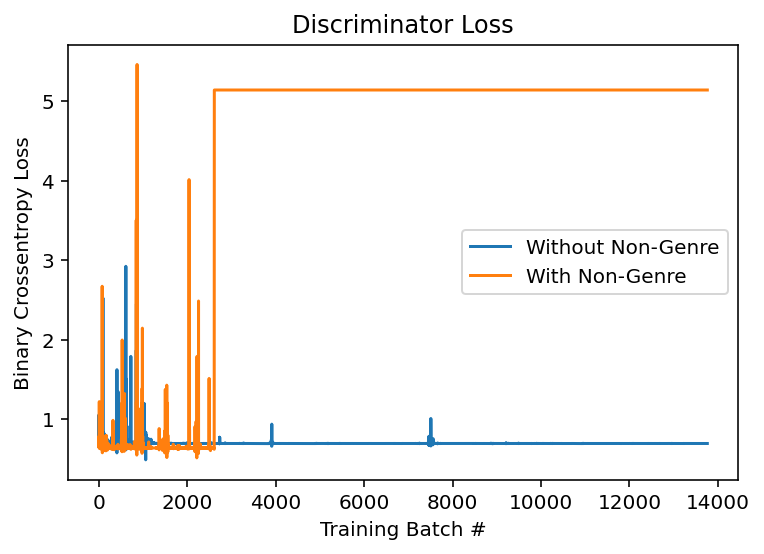

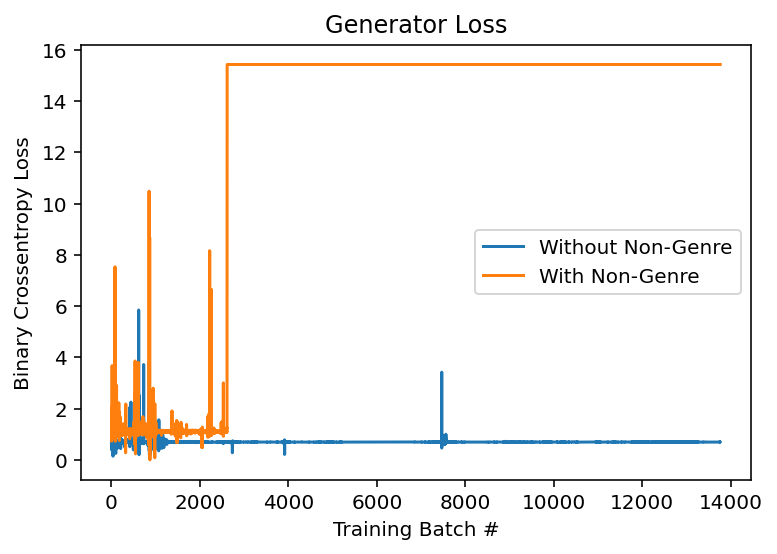

In [145]:
print(tf.shape(history))
print(len(history[0]))

d1_loss = []
g1_loss = []

for epoch in history:
  d1_epoch_loss = 0
  g1_epoch_loss = 0
  for step in epoch:
    d1_loss.append(step[0].numpy())
    g1_loss.append(step[1].numpy())

  


d2_loss = []
g2_loss = []

for epoch in history2:
  d2_epoch_loss = 0
  g2_epoch_loss = 0
  for step in epoch:
    d2_loss.append(step[0].numpy())
    g2_loss.append(step[1].numpy())

print(d1_loss)
print(d2_loss)
import matplotlib.pyplot as plt


plt.plot(range(len(d1_loss)), d1_loss, label="Without Non-Genre")
plt.plot(range(len(d2_loss)), d2_loss, label="With Non-Genre")
plt.legend()
plt.ylabel('Binary Crossentropy Loss')
plt.xlabel('Training Batch #')
plt.title('Discriminator Loss')
plt.show()


plt.plot(range(len(g1_loss)), g1_loss, label="Without Non-Genre")
plt.plot(range(len(g2_loss)), g2_loss, label="With Non-Genre")
plt.legend()
plt.ylabel('Binary Crossentropy Loss')
plt.xlabel('Training Batch #')
plt.title('Generator Loss')
plt.show()